In [2]:
import torch
import torch.nn.functional as F
import string
import matplotlib.pyplot as plt
%matplotlib inline

Dataset Link : https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [3]:
with open('../input/makemore-names/names.txt') as f:
    names = f.read().splitlines()

In [4]:
len(names)

32033

# Problem
The problem with bigrams is that we are only looking the previous character to predict the next character.

If we look back at more characters, the size of the matrix N increases exponentially.

# Instead
Paper : A Neural Probabilistic Language Model (<a href="https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf">Link</a>)
In this paper, they have used 17000 words in the vocabulary and for each word they have assigned a feature vector of dimension (30,). Hence we can say that all the 17000 words are embedded into a 30-D space.

Initially the feature vectors are random and on training the feature vectors are updated...words with similar meanings are closer to each other in the vector space and converse is true.

Modelling approach: maximize log likelihood

## Model Generalization: Example from the paper
In the training set we might have a sentence like
<ul>
    <li>the cat is walking in the bedroom.</li>
    <li>the dog is running in a room.</li>
</ul>
Due to the feature vectors, (a, the) | (cat, dog) | (room, bedroom) | (is, was) | (running, walking) might be closer together in the embedding space.
This allows the model to predict stuff like:
<ul>
    <li>the dog is walking in a ________ -> bedroom.</li>
    <li>a cat is running the the _______" -> room.</li>
</ul>

## Diagram
Input: 3 previous words
Output: 4th word

For each word, there's a one-hot index vector, and then there's the embedding vector 17000 * 30. So the dot product will result in the feature vector of that word.

# Making the dataset

In [5]:
names[ : 8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
vocab = ['.'] + list(string.ascii_lowercase)
char_to_int = {c:i for i,c in enumerate(vocab)}
int_to_char = {i:c for c,i in char_to_int.items()}

print("Char to Int : " , char_to_int , "\n")
print("Int to Char : " , int_to_char)

Char to Int :  {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26} 

Int to Char :  {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


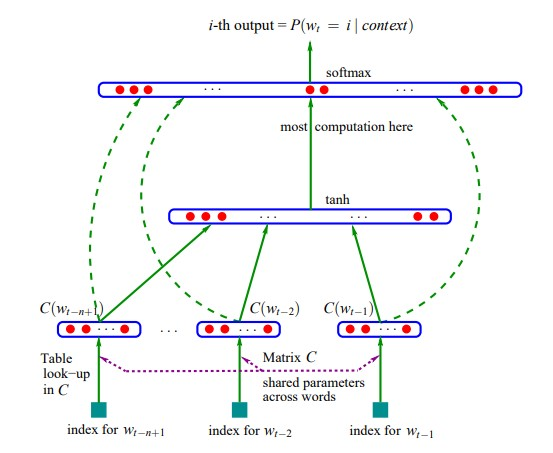

In [7]:
blockSize = 3 # Here the blocksize means how many previous characters are we looking back to predict the next character
# So from the above architecture, blocksize will lead to how many layers are contributing to the next layer's prediction. 

X , Y = [] , []
for word in names[ : 5]:
    print(word)
    context = [0] * blockSize
    for ch in word + '.':
        ix = char_to_int[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(int_to_char[i] for i in context), '-->', int_to_char[ix])
        context = context[1 : ] + [ix] # Cropping and appending, like a sliding window

emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
ava
... --> a
..a --> v
.av --> a
ava --> .
isabella
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
sophia
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [8]:
# Converting the list to torch tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [9]:
# We now need to create the lookup table C
# In the paper, they have 17000 words and embed them into 30-D space
# We have 27 possible outputs, and embed them into 2-D space

# Why embedding: embeddings are vectors created by machine learning models for the purpose of of similarity searches by that model.
# Reading This : https://www.cloudflare.com/en-gb/learning/ai/what-are-embeddings/
C = torch.randn((27 , 2))
C.shape

torch.Size([27, 2])

In [10]:
# So to find the embedding of a particular example, Pytorch allows list indexing as well
C[X[1]]

tensor([[-0.3205, -0.7081],
        [-0.3205, -0.7081],
        [-0.4892, -0.4447]])

In [11]:
C[X].shape

torch.Size([32, 3, 2])

In [12]:
# We can easily get the embedding for a particular example
embedding = C[X]

# Constructing the hidden layer 
Since our is of shape (no. of examples , blocksize , embedding dimension) i.e., (32, 3, 2) 
So the number of inputs to the hidden layer will be 6 (3 layers or blocksize and each having 2-D embedding). And the number of neurons is a hyperparameter. 

In [13]:
hiddenLayerNeurons = 100

W1 = torch.randn((6 , hiddenLayerNeurons))
b1 = torch.randn(hiddenLayerNeurons)

# Problem
For this hidden layer, we can't perform direct operation of embedding @ W1 
Reason : embedding's shape is (32 , 3 , 2) and W1's shape is (6 , 100)
So we need to transform embedding's shape from (32 , 3 , 2) to (32 , 6)

This can be done from many ways : 
<ul>
    <li>
        CONCAT
        Issue: Cannot generalize if 5 dimensional then we've to do till 4.
        <div>
            print('cat:',emb[:,0,:].shape, emb[:,1,:].shape, emb[:,2,:].shape) <br />
            print(torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]], 1).shape) <br />
            >>> cat: torch.Size([32, 2]) torch.Size([32, 2]) torch.Size([32, 2]) <br />
            >>> torch.Size([32, 6]) <br />
        </div>
    </li>
    <li>
        UNBIND: removes a tensor dimension, returns a list
        <div>
            print('cat, unbind:', torch.cat(torch.unbind(emb, 1), 1).shape) <br />
            >>> cat, unbind: torch.Size([32, 6]) <br />
        </div>
    </li>
    <li>
        VIEW: reshape 
        <div>
            print('view:',emb.view(32,6).shape) <br />
            >>> view: torch.Size([32, 6])
        </div>
    </li>
</ul>
<hr />
View is the best since it doesn't create a new tensor unlike cat and unbind and tensor representation changes internally. <br />
also, instead of doing .view(32,6), we can do .view(emb.shape[0],6) or .view(-1,6)

In [14]:
h = torch.tanh(embedding.view(-1 , 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [15]:
W2 = torch.randn((hiddenLayerNeurons , 27))
b2 = torch.randn(27)

In [16]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [17]:
counts = logits.exp()
probs = counts / counts.sum(1 , keepdims = True)
probs.shape , probs.sum(1)

(torch.Size([32, 27]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000]))

In [18]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [19]:
# From the calculated probs, we will determine the loss
loss = -probs[torch.arange(32) , Y].log().mean()
loss

tensor(17.6712)

In [20]:
# With a generator and seed
seed = 2147483647
generator = torch.Generator().manual_seed(seed)

C = torch.randn((27 , 2) , generator = generator)
W1 = torch.randn((6 , hiddenLayerNeurons) , generator = generator)
b1 = torch.randn(hiddenLayerNeurons , generator = generator)
W2 = torch.randn((hiddenLayerNeurons , 27) , generator = generator)
b2 = torch.randn(27 , generator = generator)

parameters = [C , W1 , b1 , W2 , b2]

In [21]:
# Number of parameters
params = [p.nelement() for p in parameters]
total = 0
for item in params:
    total += item
total

3481

# Improvements 
Pytorch has inbuilt function for calculating the loss
That is : F.cross_entropy(predictions , trueValues)

Reason for using this is : 
<ol>
    <li>Forward pass is much more efficient</li>
    <li>Backward pass is much more efficient</li>
    <li>Things are numerical well behaved : We will never encounter NaN or Inf</li>
</ol>

In [22]:
for p in parameters:
    p.requires_grad = True

In [23]:
# Forward Pass : 
embedding = C[X]
h = torch.tanh(embedding.view(-1 , 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits , Y)
loss

tensor(17.7697, grad_fn=<NllLossBackward0>)

In [24]:
# Backward Pass : 
for p in parameters:
    p.grad = None
    
loss.backward()

# Optimization
for p in parameters:
    p.data += (-0.1 * p.grad)

In [25]:
seed = 2147483647
g = torch.Generator().manual_seed(seed)

hidden_dim = 100
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad = True

epochs = 10
lr = 0.1

losses = []

for epoch in range(epochs):
    
    # forward pass
    
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y)
    losses.append(loss)
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    print(f"loss at epoch {epoch+1}:\t {loss.item()}")


loss at epoch 1:	 17.76971435546875
loss at epoch 2:	 13.656401634216309
loss at epoch 3:	 11.298768997192383
loss at epoch 4:	 9.452455520629883
loss at epoch 5:	 7.984262466430664
loss at epoch 6:	 6.891321182250977
loss at epoch 7:	 6.100014686584473
loss at epoch 8:	 5.452036380767822
loss at epoch 9:	 4.898151874542236
loss at epoch 10:	 4.414664268493652


### Training Loop

Here we have only 32 examples, hence we're technically overfitting a batch of 32

If we use all names we'll have 200k+ examples and we'll be forward and backward passing through all of them at once which takes a lot of compute time

Instead what we do is use mini-batches of data -- randomly selected and compute passes on those

# Training using Mini-Batches

In [26]:
# dataset

blockSize = 3 # length of context: no. of characters we use to predict the next

X, Y = [], []
for w in names:
    context = [0] * blockSize
    for ch in w + '.':
        ix = char_to_int[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append, like a rolling window
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [27]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [28]:
C = torch.randn((27,2))

In [29]:
seed = 2147483647
hidden_dim = 100

In [30]:
g = torch.Generator().manual_seed(seed)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
    
# ----------------------------------------------------------------------------------------------------

epochs = 100
learningRate = 0.1
batchSize = 32
losses = []

# ----------------------------------------------------------------------------------------------------

for epoch in range(1 , epochs + 1):
    # mini-batch creation
    ix = torch.randint(0,X.shape[0], (batchSize,)) # Taking 32 (batchSize) random integers ranging from (0 , X.shape[0])
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    losses.append(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # optimization
    for p in parameters:
        p.data += -learningRate * p.grad
        
    if epoch%(epochs//10) == 0:
        print(f"loss at epoch {epoch}:\t {loss.item()}")

loss at epoch 10:	 10.31164836883545
loss at epoch 20:	 7.3654561042785645
loss at epoch 30:	 8.194239616394043
loss at epoch 40:	 8.059215545654297
loss at epoch 50:	 6.644255638122559
loss at epoch 60:	 4.820463180541992
loss at epoch 70:	 4.272583961486816
loss at epoch 80:	 3.6254303455352783
loss at epoch 90:	 4.065574645996094
loss at epoch 100:	 3.7515406608581543


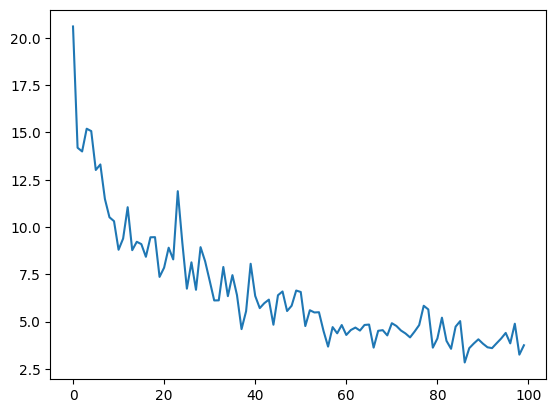

In [31]:
plt.plot(losses)

# Note
With Mini-Batches, we can train model quickly

But, the quality of the gradient is lower. This means that the direction of gradient is not reliable, i.e., not the actual direction. But the gradient direction is good enough even we are only estimating on the 32 examples. 

So, it is much to have an approximate gradient and run more steps than it is to evaluate the exact gradient and run fewer steps. 

# Determing a good learning rate

In [32]:
lr_exp = torch.linspace(-3,0,1000)
lrs = 10**lr_exp # exponential spacing between LRs

In [33]:
g = torch.Generator().manual_seed(seed)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
    
# ------------

epochs = 1000
batch_size = 32
losses = []

for epoch in range(1,epochs+1):
    
    # mini-batch creation
    ix = torch.randint(0,X.shape[0], (batch_size,))
    
    # forward pass
    
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y[ix])
    losses.append(loss.item())
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    # getting lr
    lr = lrs[epoch-1]
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    if epoch%(epochs//10) == 0:
        print(f"loss at epoch {epoch}:\t {loss.item()}")

# After we some good number of epochs on mini batches, we will find the current loss for the entire dataset
# --- total loss

emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print("\nTotal Loss:",loss.item())

loss at epoch 100:	 17.355579376220703
loss at epoch 200:	 14.027233123779297
loss at epoch 300:	 10.311713218688965
loss at epoch 400:	 8.094285011291504
loss at epoch 500:	 5.998419761657715
loss at epoch 600:	 4.432333946228027
loss at epoch 700:	 3.017542839050293
loss at epoch 800:	 3.3468902111053467
loss at epoch 900:	 3.2091853618621826
loss at epoch 1000:	 5.727004528045654

Total Loss: 7.718480110168457


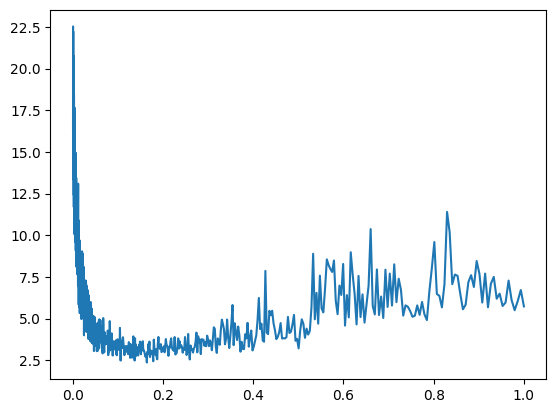

In [34]:
plt.plot(lrs, losses)

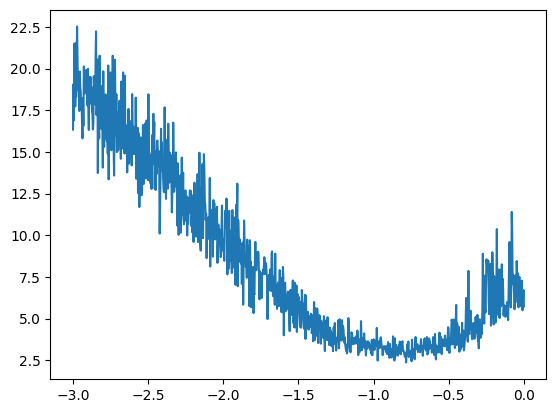

In [35]:
plt.plot(lr_exp, losses)

From the above graphs, we notice that the losses explode at some LR value after 10**-1, hence lr=0.1 is pretty decent

<strong>Let's train for 30000 epochs with lr decay after 20k and 28k epochs</strong>

In [36]:
g = torch.Generator().manual_seed(seed)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
    
# ------------

epochs = 30000
lr = 0.1
batch_size = 32
losses = []

for epoch in range(1,epochs+1):
    
    # mini-batch creation
    ix = torch.randint(0,X.shape[0], (batch_size,))
    
    # forward pass
    
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y[ix])
    losses.append(loss.item())
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    # update lr
    if epoch > 20000:
        lr = 0.01
    elif epoch > 28000:
        lr = 0.001
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    if epoch%3000 == 0:
        print(f"loss at epoch {epoch}:\t {loss.item()}")
        
# --- total loss
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print("\nTotal Loss:",loss.item())

loss at epoch 3000:	 2.6295177936553955
loss at epoch 6000:	 2.383303165435791
loss at epoch 9000:	 2.310394287109375
loss at epoch 12000:	 2.476529359817505
loss at epoch 15000:	 2.409693956375122
loss at epoch 18000:	 2.4290218353271484
loss at epoch 21000:	 2.224004030227661
loss at epoch 24000:	 2.0958871841430664
loss at epoch 27000:	 2.363126277923584
loss at epoch 30000:	 2.507852554321289

Total Loss: 2.3640859127044678


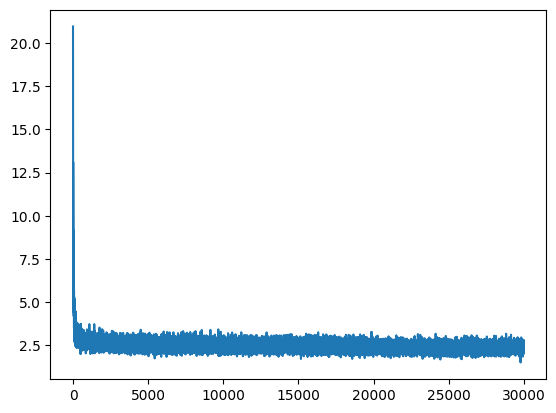

In [37]:
plt.plot(losses)

# Train-Val-Test Split
As the capacity of neural network grows, so does it ability to overfit. Sampling without split, we'll get examples that already exists in the names list

So we will split the data into training, validation and test data.
train = 0.8 <br />
    -> This is used to optimize the parameters of the model. <br />
validation = 0.1 <br />
    -> This is used to develop and check which hyperparameters suits our model best. <br />
test = 0.1 <br />
    -> This is used to evaluate the model. We are only allowed to test our model few times, because if you keep testing, it will learn that as well and might overfit the model.<br />

In [44]:
def build_dataset(names, block_size=3):
    X, Y = [], []
    for w in names:
        context = [0] * block_size
        for ch in w + '.':
            ix = char_to_int[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append, like a rolling window

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

In [45]:
X, Y = build_dataset(names)

torch.Size([228146, 3]) torch.Size([228146])


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=True,stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_val,Y_val, test_size=0.5,random_state=52,shuffle=True,stratify=Y_val)

In [48]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

(torch.Size([182516, 3]),
 torch.Size([182516]),
 torch.Size([22815, 3]),
 torch.Size([22815]),
 torch.Size([22815, 3]),
 torch.Size([22815]))

## Hyperparameters

In [49]:
seed = 2147483647
hidden_dim = 100
lr = 0.1
epochs = 30000
batch_size = 32

## Training with Train Set with Learning Rate Decay

In [50]:
g = torch.Generator().manual_seed(seed)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
    
# ------------
losses = []

for epoch in range(1,epochs+1):
    
    # mini-batch creation
    ix = torch.randint(0,X_train.shape[0], (batch_size,))
    
    # forward pass
    
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y_train[ix])
    losses.append(loss.item())
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    # lr decay
    if epoch > 20000:
        lr = 0.01
    elif epoch > 28000:
        lr = 0.001
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    if epoch%1000 == 0:
        print(f"loss at epoch {epoch}:\t {loss.item()}")
        
# --- Train loss
emb = C[X_train]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print("\nTrain Loss:",loss.item())

loss at epoch 1000:	 2.806922435760498
loss at epoch 2000:	 2.5054986476898193
loss at epoch 3000:	 2.5049705505371094
loss at epoch 4000:	 2.743732213973999
loss at epoch 5000:	 2.3526880741119385
loss at epoch 6000:	 2.840024471282959
loss at epoch 7000:	 2.5984959602355957
loss at epoch 8000:	 2.682293176651001
loss at epoch 9000:	 2.502833843231201
loss at epoch 10000:	 2.6192259788513184
loss at epoch 11000:	 2.4478158950805664
loss at epoch 12000:	 2.289417028427124
loss at epoch 13000:	 2.558448314666748
loss at epoch 14000:	 2.3393781185150146
loss at epoch 15000:	 2.6404459476470947
loss at epoch 16000:	 2.4766626358032227
loss at epoch 17000:	 2.8074564933776855
loss at epoch 18000:	 2.5407049655914307
loss at epoch 19000:	 2.5006024837493896
loss at epoch 20000:	 2.349760055541992
loss at epoch 21000:	 2.3385226726531982
loss at epoch 22000:	 2.1039931774139404
loss at epoch 23000:	 2.271975040435791
loss at epoch 24000:	 2.631699800491333
loss at epoch 25000:	 2.14946866035

### Note
Training Loss ~= Validation Loss <br />
This shows that the model is not overfitting

In [51]:
# --- Validation loss
emb = C[X_val]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
print("\nValidation Loss:",loss.item())


Validation Loss: 2.3681206703186035


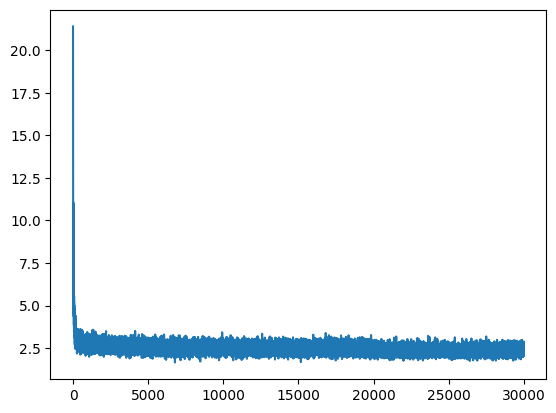

In [52]:
plt.plot(losses)

### Trying different set of hyperparameters

In [53]:
seed = 2147483647
hidden_dim = 512
lr = 0.1
epochs = 60000
batch_size = 64

In [54]:
g = torch.Generator().manual_seed(seed)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
    
# ------------
losses = []

for epoch in range(1,epochs+1):
    
    # mini-batch creation
    ix = torch.randint(0,X_train.shape[0], (batch_size,))
    
    # forward pass
    
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y_train[ix])
    losses.append(loss.item())
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    # lr decay
    if epoch > 45000:
        lr = 0.01
    elif epoch > 58000:
        lr = 0.001
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    if epoch%3000 == 0:
        print(f"loss at epoch {epoch}:\t {loss.item()}")
        
# --- Train loss
emb = C[X_train]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print("\nTrain Loss:",loss.item())

loss at epoch 3000:	 2.9571948051452637
loss at epoch 6000:	 3.1522183418273926
loss at epoch 9000:	 2.429826259613037
loss at epoch 12000:	 2.6084914207458496
loss at epoch 15000:	 2.5398647785186768
loss at epoch 18000:	 2.55954909324646
loss at epoch 21000:	 2.7533040046691895
loss at epoch 24000:	 2.346958637237549
loss at epoch 27000:	 2.411471366882324
loss at epoch 30000:	 2.475588083267212
loss at epoch 33000:	 2.868067741394043
loss at epoch 36000:	 2.570152759552002
loss at epoch 39000:	 2.849749803543091
loss at epoch 42000:	 2.3818745613098145
loss at epoch 45000:	 2.512360095977783
loss at epoch 48000:	 2.124650716781616
loss at epoch 51000:	 2.397021770477295
loss at epoch 54000:	 2.171321392059326
loss at epoch 57000:	 2.24971079826355
loss at epoch 60000:	 2.042776584625244

Train Loss: 2.2670705318450928


In [55]:
# --- Validation loss
emb = C[X_val]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
print("\nValidation Loss:",loss.item())

# --- Test loss
emb = C[X_test]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)
print("\nTest Loss:",loss.item())


Validation Loss: 2.2860233783721924

Test Loss: 2.29498553276062


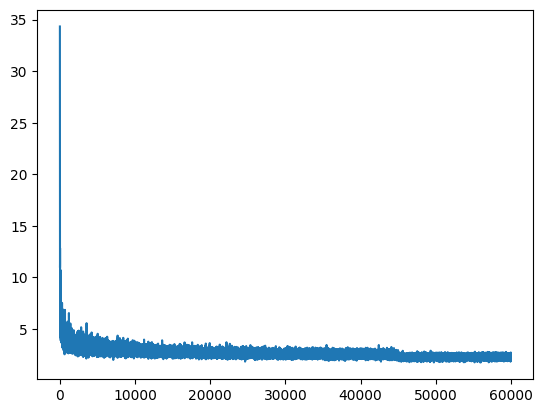

In [56]:
plt.plot(losses)

## Visualizing the embedding space

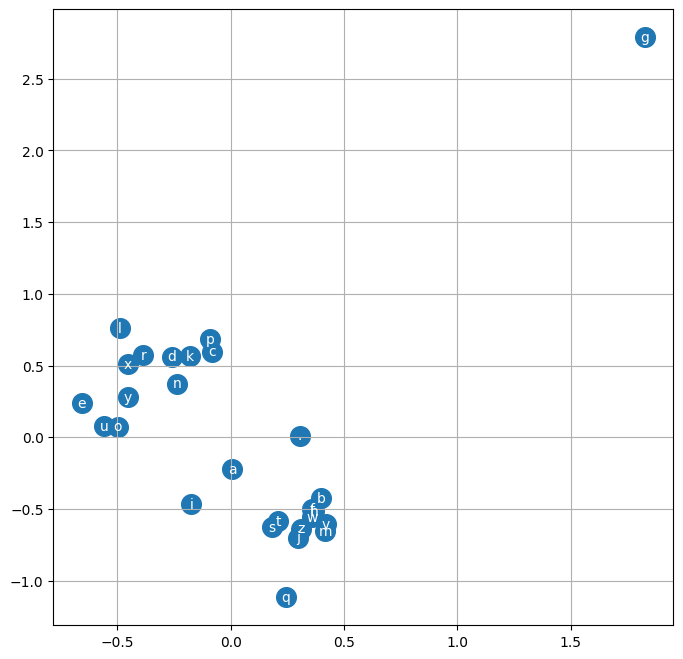

In [58]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),int_to_char[i], ha='center', va='center', color='white')
plt.grid('minor')

### We can see some grouping in the above image.

# Trying different embedding size

In [59]:
seed = 2147483647
hidden_dim = 200
lr = 0.1
epochs = 100000
batch_size = 32

In [60]:
g = torch.Generator().manual_seed(seed)
C = torch.randn((27,5), generator=g)
W1 = torch.randn((3*5,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
    
# ------------
log_losses = []

for epoch in range(1,epochs+1):
    
    # mini-batch creation
    ix = torch.randint(0,X_train.shape[0], (batch_size,))
    
    # forward pass
    
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1,3*5) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y_train[ix])
    log_losses.append(loss.log10().item())
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    if epoch > 50000:
        lr = 0.01
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    if epoch%(epochs//10) == 0:
        print(f"loss at epoch {epoch}:\t {loss.item()}")
        
# --- Train loss
emb = C[X_train]
h = torch.tanh(emb.view(-1,3*5) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print("\nTrain Loss:",loss.item())

loss at epoch 10000:	 2.8624322414398193
loss at epoch 20000:	 2.4813191890716553
loss at epoch 30000:	 2.8387980461120605
loss at epoch 40000:	 2.8571250438690186
loss at epoch 50000:	 2.1185505390167236
loss at epoch 60000:	 2.338750123977661
loss at epoch 70000:	 2.258342981338501
loss at epoch 80000:	 1.9246021509170532
loss at epoch 90000:	 2.0765466690063477
loss at epoch 100000:	 2.2579755783081055

Train Loss: 2.224601984024048


In [61]:
# --- Validation loss
emb = C[X_val]
h = torch.tanh(emb.view(-1,3*5) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
print("\nValidation Loss:",loss.item())

# --- Test loss
emb = C[X_test]
h = torch.tanh(emb.view(-1,3*5) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)
print("\nTest Loss:",loss.item())


Validation Loss: 2.242664098739624

Test Loss: 2.2502822875976562


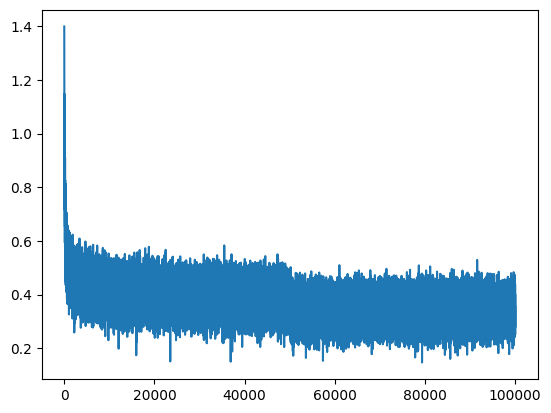

In [62]:
plt.plot(log_losses)

# A Complete New Set of Hyperparameters

In [63]:
seed = 42
hidden_dim = 512
lr = 0.1
epochs = 100000
batch_size = 64
emb_dim = 5
block_size = 4

In [65]:
def build_dataset(names, block_size=3):
    X, Y = [], []
    for w in names:
        context = [0] * block_size
        for ch in w + '.':
            ix = char_to_int[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append, like a rolling window

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

X,Y = build_dataset(names, block_size=block_size)

torch.Size([228146, 4]) torch.Size([228146])


In [66]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=True,stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_val,Y_val, test_size=0.5,random_state=52,shuffle=True,stratify=Y_val)

In [67]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

(torch.Size([182516, 4]),
 torch.Size([182516]),
 torch.Size([22815, 4]),
 torch.Size([22815]),
 torch.Size([22815, 4]),
 torch.Size([22815]))

In [69]:
g = torch.Generator().manual_seed(seed)
C = torch.randn((27,emb_dim), generator=g)
W1 = torch.randn((block_size*emb_dim,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
    
# ------------
log_train_losses = []
log_val_losses = []

for epoch in range(1,epochs+1):
    
    # mini-batch creation
    ix = torch.randint(0,X_train.shape[0], (batch_size,))
    
    # forward pass
    
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y_train[ix])
    log_train_losses.append(loss.log10().item())
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    if epoch > 60000:
        lr = 0.01
    elif epoch > 90000:
        lr = 0.001
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    if epoch%(epochs//10) == 0:
        print(f"train loss at epoch {epoch}:\t {loss.item()}")
        
    if epoch%(epochs//5) == 0:
        with torch.no_grad():
            print('-'*30)
            emb = C[X_val]
            h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1)
            logits = h @ W2 + b2
            loss = F.cross_entropy(logits, Y_val)
            print(f"val loss at epoch {epoch}:\t {loss.item()}\n{'-'*30}")
            log_val_losses.append(loss.log10().item())
            
        
        
# --- Train loss
emb = C[X_train]
h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print("\nTrain Loss:",loss.item())

train loss at epoch 10000:	 2.9635744094848633
train loss at epoch 20000:	 3.5264554023742676
------------------------------
val loss at epoch 20000:	 2.8235671520233154
------------------------------
train loss at epoch 30000:	 3.4324281215667725
train loss at epoch 40000:	 2.709101915359497
------------------------------
val loss at epoch 40000:	 2.5338408946990967
------------------------------
train loss at epoch 50000:	 2.673961877822876
train loss at epoch 60000:	 2.457669496536255
------------------------------
val loss at epoch 60000:	 2.477750301361084
------------------------------
train loss at epoch 70000:	 2.1128082275390625
train loss at epoch 80000:	 2.3825294971466064
------------------------------
val loss at epoch 80000:	 2.1988141536712646
------------------------------
train loss at epoch 90000:	 2.239424467086792
train loss at epoch 100000:	 2.577815532684326
------------------------------
val loss at epoch 100000:	 2.202255964279175
------------------------------


In [70]:
# --- Test loss
emb = C[X_test]
h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)
print("\nTest Loss:",loss.item())


Test Loss: 2.207162618637085


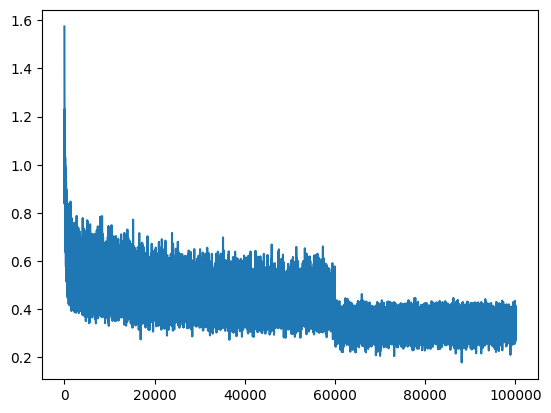

In [71]:
plt.plot(log_train_losses)

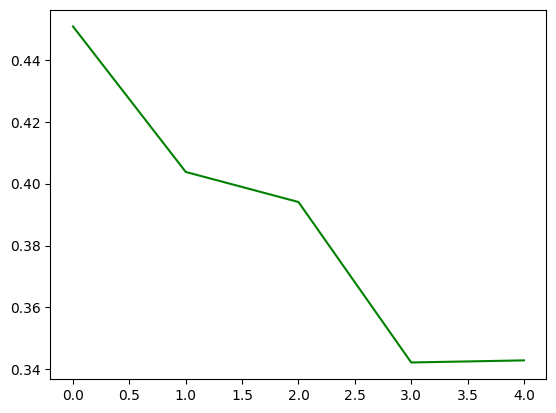

In [72]:
plt.plot(log_val_losses, color='green')

### Sampling

In [78]:
g = torch.Generator().manual_seed(45)

for _ in range(20):
    
    name = ''
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs, num_samples=1,generator=g).item()
        context = context[1:] + [ix]
        name += int_to_char[ix]
        if ix == 0:
            break
            
    print(name)

nasmy.
xaqua.
villiat.
dura.
lakyn.
dhore.
danaralai.
rowee.
rexelandry.
jhow.
suretolah.
aray.
aaventon.
zatina.
joyley.
anay.
vame.
shadie.
nycalynney.
aniph.
